In [1]:
from hamiltonian import HamiltonianSmall, Hamiltonian

In [2]:
lih_small = HamiltonianSmall('LiH', 1.5) # this encoding uses reduction techniques
beh2_small = HamiltonianSmall('BeH2', 1.3) # this encoding uses reduction techniques

# 4 qubits
h2_jw_4 = Hamiltonian('H2_STO3g_4qubits', 'jw')
h2_parity_4 = Hamiltonian('H2_STO3g_4qubits', 'parity')
h2_bk_4 = Hamiltonian('H2_STO3g_4qubits', 'bk')

# 8 qubits
h2_jw = Hamiltonian('H2_6-31G_8qubits', 'jw')
h2_parity = Hamiltonian('H2_6-31G_8qubits', 'parity')
h2_bk = Hamiltonian('H2_6-31G_8qubits', 'bk')

# 12 qubits
lih_jw = Hamiltonian('LiH_STO3g_12qubits', 'jw')
lih_parity = Hamiltonian('LiH_STO3g_12qubits', 'parity')
lih_bk = Hamiltonian('LiH_STO3g_12qubits', 'bk')

# 14 qubits
h2o_jw = Hamiltonian('H2O_STO3g_14qubits', 'jw')
h2o_parity = Hamiltonian('H2O_STO3g_14qubits', 'parity')
h2o_bk = Hamiltonian('H2O_STO3g_14qubits', 'bk')

beh2_jw = Hamiltonian('BeH2_STO3g_14qubits', 'jw')
beh2_parity = Hamiltonian('BeH2_STO3g_14qubits', 'parity')
beh2_bk = Hamiltonian('BeH2_STO3g_14qubits', 'bk')

# 16 qubits
nh3_jw = Hamiltonian('NH3_STO3g_16qubits', 'jw')
nh3_parity = Hamiltonian('NH3_STO3g_16qubits', 'parity')
nh3_bk = Hamiltonian('NH3_STO3g_16qubits', 'bk')

# 20 qubits
c2_jw = Hamiltonian('C2_STO3g_20qubits', 'jw')
c2_parity = Hamiltonian('C2_STO3g_20qubits', 'parity')
c2_bk = Hamiltonian('C2_STO3g_20qubits', 'bk')

In [3]:
%time h2_jw_4.pauli_rep.ground()
%time h2_jw.pauli_rep.ground()
%time lih_jw.pauli_rep.ground()
%time energy, state = h2o_jw.pauli_rep.ground()
# %time energy, state = nh3_jw.pauli_rep.ground() # takes about 4 minutes

CPU times: user 20.1 ms, sys: 1.83 ms, total: 21.9 ms
Wall time: 20.4 ms
CPU times: user 499 ms, sys: 25.6 ms, total: 524 ms
Wall time: 412 ms
CPU times: user 4.24 s, sys: 315 ms, total: 4.55 s
Wall time: 2.48 s
CPU times: user 21 s, sys: 2.25 s, total: 23.2 s
Wall time: 9.4 s


In [4]:
%time h2_jw_4.pauli_rep.ground(multithread=True)
%time h2_jw.pauli_rep.ground(multithread=True)
%time lih_jw.pauli_rep.ground(multithread=True)
%time energy, state = h2o_jw.pauli_rep.ground(multithread=True)
# %time energy, state = ammonia_jw.pauli_rep.ground(multithread=True) # takes about 1 minute

CPU times: user 52.9 ms, sys: 57.7 ms, total: 111 ms
Wall time: 332 ms
CPU times: user 185 ms, sys: 76.1 ms, total: 261 ms
Wall time: 464 ms
CPU times: user 1.4 s, sys: 254 ms, total: 1.65 s
Wall time: 937 ms
CPU times: user 21.8 s, sys: 2.68 s, total: 24.5 s
Wall time: 4.49 s


# Variance formula

\begin{align}
    \Var[\nu] 
    &=
    \sum_{\Qarrow,\Rarrow}
        f_\beta(\Qarrow,\Rarrow)
        \alpha_\Qarrow \alpha_\Rarrow
        \tr(\rho\Qarrow\Rarrow)
    - \tr(\rho H_0 )^2
\end{align}

In [5]:
ham = h2_jw_4
energy, state = ham.pauli_rep.ground()
β = ham.pauli_rep.local_dists_uniform()
%time ham.pauli_rep.variance_local(energy, state, β)

CPU times: user 18.9 ms, sys: 4.65 ms, total: 23.6 ms
Wall time: 3.03 ms


1.9710775636478903

In [6]:
print("ell_1: ", ham.pauli_rep.variance_ell_1(energy))

ell_1:  2.493466775932121


In [7]:
# this code is from an old idea, which ultimately did not work well.

β = ham.pauli_rep.local_dists_pnorm(1)
print("1_norm: ", ham.pauli_rep.variance_local(energy, state, β))

β = ham.pauli_rep.local_dists_pnorm(2)
print("2_norm: ", ham.pauli_rep.variance_local(energy, state, β))

β = ham.pauli_rep.local_dists_pnorm('infinity')
print("max_norm: ", ham.pauli_rep.variance_local(energy, state, β))

1_norm:  60.38753187541104
2_norm:  22.36573743732807
max_norm:  13.643445555482327


# Variance optimisation (keyword=diagonal)

This is not the correct optimisation. However it
- gives good results;
- is quicker than the full optimisation problem;
- is convex (so local minimums are global);
- does not need access to the Hartree-Fock bitstring for the encoding.

Diagonal minimisation asks us to find $\{\beta_{i,P}\}$ in order to minimise:
$$
    \sum_{\Qarrow} \alpha_\Qarrow^2 \prod_{i\in\supp(\Qarrow)} \beta_{i,Q_i}^{-1}
    \qquad
    \textrm{subject to}
    \qquad
    \beta_{i,X}+\beta_{i,Y}+\beta_{i,Z}=1 \,\forall i,
    \qquad
    \beta_{i,P}\ge 0
$$

In [8]:
β_optimal_diagonal = ham.pauli_rep.local_dists_optimal('diagonal')
print(ham.pauli_rep.variance_local(energy, state, β_optimal_diagonal))

1.8555808969284264


# Variance optimisation (keyword=mixed)

This is the full optimisation problem. It requires access to the Hartree-Fock bitstring $m$ or `bitstring_HF` so that the HF state reads
$\frac1{2^n}\otimes_{i=1}^n (I+m_i Z)$

In the JW encoding these are:
- H2 = `1010` (on four qubits)
- H2 = `10001000`
- LiH = `100000100000`
- H2O = `11111001111100`
- BeH2 = `11100001110000`
- NH3 = `1111100011111000`
You can retrieve them by calling `Hamiltonian.read_bitstring_HF()`

Consider the set of influential pairs:
\begin{align}
    \mathcal{I}_\mathrm{comp}
    =
    \left\{\left.
        (\Qarrow,\Rarrow)
        \,\right|\,
        \textrm{for all $i$, either $Q_i=R_i$, or $\{Q_i,R_i\}=\{I,Z\}$}
    \right\}
\end{align}

Then the cost function to optimise will be:
\begin{align}
    \mathrm{cost}(\{\beta_i\}_{i=1}^n)
    =
    \sum_{\Qarrow,\Rarrow\in\mathcal{I}_\mathrm{comp}}
        \alpha_\Qarrow
        \alpha_\Rarrow
        \prod_{i | Q_i=R_i\neq I}
            \beta_{i,Q_i}^{-1}
        \prod_{i | Q_i\neq R_i}
            m_i
\end{align}

Warning, the small Hamiltonians don't follow the pattern because they use other reduction techniques

In [9]:
bitstring_HF = ham.read_bitstring_HF()
β_optimal_mixed = ham.pauli_rep.local_dists_optimal('mixed', bitstring_HF)
print(ham.pauli_rep.variance_local(energy, state, β_optimal_mixed))

1.8546562425124495


# Variance after LDF grouping

We should use 1-norm sampling for $\kappa$

\begin{align}
    \Var[\nu] 
    = 
    \left(
    \sum_{k=1}^{n_c}
        \frac1{\kappa_k} 
        \sum_{\Qarrow,\Rarrow\in C^{(k)}}
            \alpha_\Qarrow\alpha_\Rarrow
            \prod_{i\in\supp(\Qarrow\Rarrow)} \langle \Qarrow\Rarrow \rangle
    \right)
    - \langle H_0 \rangle^2
\end{align}

In [10]:
from var import variance_ldf, kappa_1norm #kappa_uniform

In [11]:
ldf = ham.ldf()
kappa = kappa_1norm(ldf)
energy_tf = ham.pauli_rep.energy_tf(energy)
variance_ldf(ldf, state, kappa, energy_tf)

0.4018197080691306

# Benchmarking

In [12]:
def variances_dict(ham, β_diag=None, β_mix=None):
    pr = ham.pauli_rep
    dic = {}
    
    energy, state = pr.ground(multithread=True)
    print("energy :", energy)

    # ell_1
    var = pr.variance_ell_1(energy)
    print("ell 1: ", var)
    dic['ell_1'] = var
    
    # LDF with 1-norm sampling
    ldf = ham.ldf()
    kappa = kappa_1norm(ldf)
    energy_tf = pr.energy_tf(energy)
    var = variance_ldf(ldf, state, kappa, energy_tf)
    print("ldf 1norm: ", var)
    dic['ldf_1norm'] = var
    
    # uniform
    β_uniform = pr.local_dists_uniform()
    var = pr.variance_local(energy, state, β_uniform, multithread=True)
    print("uniform: ", var)
    dic['uniform'] = var
    
    # optimal (diagonal)
    if β_diag is not None:
        var = pr.variance_local(energy, state, β_diag, multithread=True)
        print("optimal diagonal: ", var)
        dic['optimal_diag'] = var
 
    # optimal (mixed)
    if β_mix is not None:
        var = pr.variance_local(energy, state, β_mix, multithread=True)
        print("optimal mixed: ", var)
        dic['optimal_mix'] = var
    
    return dic

from matplotlib import pyplot as plt

def variances_graph(variances):
    num_variances = len(variances)
    x = range(num_variances)
    height = list(variances.values())

    plt.bar(x, height)
    plt.xticks(x, list(variances.keys()), rotation=20)
    plt.title(title)

    plt.show()

In [13]:
variances_ALL = {}
beta_optimal_ALL = {}

In [14]:
name = 'h2_jw_4'
ham = h2_jw_4
bitstring_HF = ham.read_bitstring_HF()

title = "Variances for various algorithms on H2 in JW encoding over 4 qubits"

%time β_diag = ham.pauli_rep.local_dists_optimal('diagonal')
%time β_mix = ham.pauli_rep.local_dists_optimal('mixed', bitstring_HF)
beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}

%time variances_ALL[name] = variances_dict(ham, β_diag=β_diag, β_mix=β_mix)

print("=====")
print(title)
print("=====")
variances_ALL[name]

CPU times: user 97.7 ms, sys: 10.4 ms, total: 108 ms
Wall time: 37.6 ms
CPU times: user 146 ms, sys: 13.1 ms, total: 159 ms
Wall time: 53.4 ms
energy : -1.8572750302023784
ell 1:  2.493466775932128
ldf 1norm:  0.40181970806913836
uniform:  1.9710775636478985
optimal diagonal:  1.8555808969284346
optimal mixed:  1.8546562425124573
CPU times: user 121 ms, sys: 217 ms, total: 338 ms
Wall time: 1.7 s
=====
Variances for various algorithms on H2 in JW encoding over 4 qubits
=====


{'ell_1': 2.493466775932128,
 'ldf_1norm': 0.40181970806913836,
 'uniform': 1.9710775636478985,
 'optimal_diag': 1.8555808969284346,
 'optimal_mix': 1.8546562425124573}

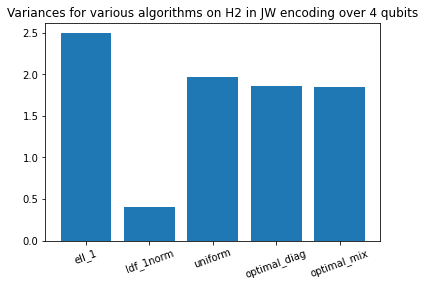

In [15]:
variances_graph(variances_ALL[name])

In [16]:
name = 'h2_jw'
ham = h2_jw
bitstring_HF = ham.read_bitstring_HF()

title = "Variances for various algorithms on H2 in JW encoding over 8 qubits"

%time β_diag = ham.pauli_rep.local_dists_optimal('diagonal')
%time β_mix = ham.pauli_rep.local_dists_optimal('mixed', bitstring_HF)
beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}

%time variances_ALL[name] = variances_dict(ham, β_diag=β_diag, β_mix=β_mix)

print("=====")
print(title)
print("=====")
variances_ALL[name]

CPU times: user 7.3 s, sys: 808 ms, total: 8.11 s
Wall time: 1.57 s


/opt/anaconda3/envs/qiskit18/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:183: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


CPU times: user 1min 14s, sys: 7.36 s, total: 1min 21s
Wall time: 18.8 s
energy : -1.8608605555207611
ell 1:  119.67906001905908
ldf 1norm:  22.259477922991238
uniform:  51.39982021387599
optimal diagonal:  17.742071936811513
optimal mixed:  17.45719070410454
CPU times: user 654 ms, sys: 288 ms, total: 942 ms
Wall time: 2.23 s
=====
Variances for various algorithms on H2 in JW encoding over 8 qubits
=====


{'ell_1': 119.67906001905908,
 'ldf_1norm': 22.259477922991238,
 'uniform': 51.39982021387599,
 'optimal_diag': 17.742071936811513,
 'optimal_mix': 17.45719070410454}

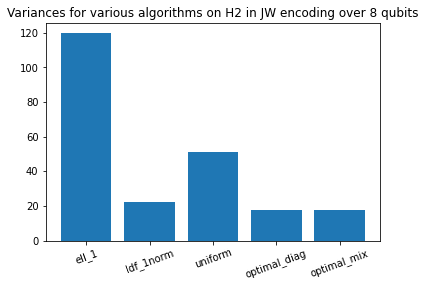

In [17]:
variances_graph(variances_ALL[name])

In [18]:
name = 'lih_jw'
ham = lih_jw
bitstring_HF = ham.read_bitstring_HF()

title = "Variances for various algorithms on LiH in JW encoding over 12 qubits"

%time β_diag = ham.pauli_rep.local_dists_optimal('diagonal')
%time β_mix = ham.pauli_rep.local_dists_optimal('mixed', bitstring_HF)
beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}

%time variances_ALL[name] = variances_dict(ham, β_diag=β_diag, β_mix=β_mix)

print("=====")
print(title)
print("=====")
variances_ALL[name]

CPU times: user 1min 8s, sys: 7.4 s, total: 1min 15s
Wall time: 12.6 s
CPU times: user 5min 39s, sys: 13.7 s, total: 5min 53s
Wall time: 3min 58s
energy : -8.908299431473647
ell 1:  138.38018090986637
ldf 1norm:  54.150863863723835
uniform:  265.63532330207994
optimal diagonal:  14.79270259129585
optimal mixed:  14.877576449531823
CPU times: user 3.07 s, sys: 550 ms, total: 3.62 s
Wall time: 17.1 s
=====
Variances for various algorithms on LiH in JW encoding over 12 qubits
=====


{'ell_1': 138.38018090986637,
 'ldf_1norm': 54.150863863723835,
 'uniform': 265.63532330207994,
 'optimal_diag': 14.79270259129585,
 'optimal_mix': 14.877576449531823}

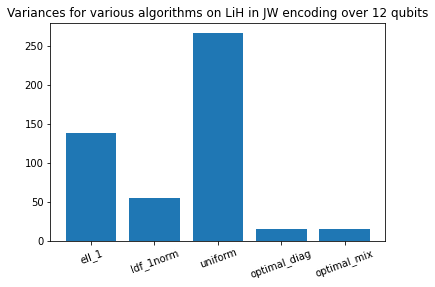

In [19]:
variances_graph(variances_ALL[name])

In [21]:
name = 'h2o_jw'
ham = h2o_jw
bitstring_HF = ham.read_bitstring_HF()

title = "Variances for various algorithms on H2O in JW encoding over 14 qubits"

%time β_diag = ham.pauli_rep.local_dists_optimal('diagonal')
%time β_mix = ham.pauli_rep.local_dists_optimal('mixed', bitstring_HF)
beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}

%time variances_ALL[name] = variances_dict(ham, β_diag=β_diag, β_mix=β_mix)

print("=====")
print(title)
print("=====")
variances_ALL[name]

CPU times: user 6min 45s, sys: 1min 1s, total: 7min 46s
Wall time: 51.6 s
CPU times: user 25min 34s, sys: 1min 23s, total: 26min 57s
Wall time: 17min 40s
energy : -83.59943020533814
ell 1:  4363.49777312606
ldf 1norm:  1041.8235013468766
uniform:  2839.039468218959
optimal diagonal:  257.5450993727736
optimal mixed:  254.14108178948436
CPU times: user 23.8 s, sys: 2.7 s, total: 26.5 s
Wall time: 2min 33s
=====
Variances for various algorithms on H2O in JW encoding over 14 qubits
=====


{'ell_1': 4363.49777312606,
 'ldf_1norm': 1041.8235013468766,
 'uniform': 2839.039468218959,
 'optimal_diag': 257.5450993727736,
 'optimal_mix': 254.14108178948436}

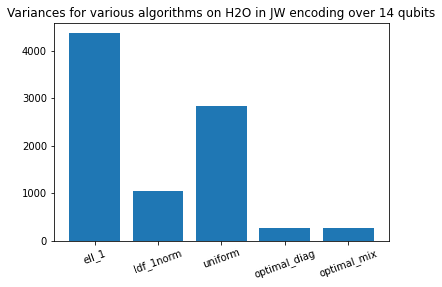

In [22]:
variances_graph(variances_ALL[name])

In [ ]:
# mac book pro is too weak for this!

#name = 'nh3_jw'
#ham = nh3_jw
#bitstring_HF = ham.read_bitstring_HF()

#title = "Variances for various algorithms on ammonia in JW encoding over 14 qubits"

#%time β_diag = ham.pauli_rep.local_dists_optimal('diagonal')
# rudy needs to help me! this will take too long using my pedestrian approach
#%time β_mix = ham.pauli_rep.local_dists_optimal('mixed', bitstring_HF)
#beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}

#%time variances_ALL[name] = variances_dict(ham, β_diag=β_diag)#, β_mix=β_mix)

#print("=====")
#print(title)
#print("=====")
#variances_ALL[name]